## Setup

In [1]:
from google.colab import output
!pip install kaggle;
!pip install torch torchvision;
!pip install opencv-python scikit-learn;
output.clear()

In [2]:
from google.colab import files
files.upload()  # subir 1k labels
files.upload()  # mapped indices
files.upload()  # sube tu kaggle.json que tienes que descargar desde tu cuenta de kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# descargar el set al path...
!kaggle datasets download -d ambityga/imagenet100 -p /content/imagenet100 --unzip
# quedarme solo con las carpeta y archivo que importan y borrar el resto
!mv /content/imagenet100/val.X /content/val.X
!mv /content/imagenet100/Labels.json /content/Labels.json
!rm -rf /content/imagenet100

Saving mapped_indices.json to mapped_indices.json


Saving imagenet_labels.json to imagenet_labels.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ambityga/imagenet100
License(s): unknown
100% 16.1G/16.1G [14:42<00:00, 21.5MB/s]
100% 16.1G/16.1G [14:42<00:00, 19.6MB/s]


In [3]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

import os
import sys
import json
from tqdm import tqdm

project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import glob
from torch.utils.data import Dataset


In [4]:
class ImageNet100(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform

        with open(os.path.join(root, "Labels.json"), "rb") as f:
            json_file = json.load(f)
            self.class_to_id = {class_id[0]:idx for idx, class_id in enumerate(json_file.items())}

        samples_dir = os.path.join(root, split)

        for entry in os.listdir(samples_dir):
            target = self.class_to_id[entry]
            class_sample_path = glob.glob(f"{samples_dir}/{entry}/*")
            self.samples += class_sample_path
            self.targets += [target]*len(class_sample_path)

    def __len__(self):
            return len(self.samples)

    def __getitem__(self, idx):
            x = Image.open(self.samples[idx]).convert("RGB")
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]

In [5]:
from torchvision.models import VGG16_Weights
from torchvision.models import ResNet50_Weights

In [6]:
device='cuda:0'

## Work Flow

In [7]:
#@title Model and dataloader
def load_model_and_dataloader(model: str, val_set: str, batch_size: int):
  global device
  if model == 'vgg':
    weights = VGG16_Weights.DEFAULT
    preprocess = weights.transforms()
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

  elif model == 'resnet':
    weights = ResNet50_Weights.DEFAULT
    preprocess = weights.transforms()
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

  model.to(device)
  model.eval();

  test_data = ImageNet100('/content/', val_set, preprocess)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  return model, test_loader

In [8]:
#@title Load labels
def get_labels():
  with open("/content/imagenet_labels.json", "rb") as f:
        imgnet1k_labels = json.load(f)
        imgnet1k_labels = {int(k):v for k,v in imgnet1k_labels.items()}

  with open("/content/Labels.json", "rb") as f:
        json_file = json.load(f)
        imgnet100_labels = {idx:class_id[1] for idx, class_id in enumerate(json_file.items())}

  with open("/content/mapped_indices.json", "r") as f:
        mapped_indices = json.load(f)
        mapped_indices = {int(k): v for k, v in mapped_indices.items()}

  return imgnet1k_labels, imgnet100_labels, mapped_indices

In [ ]:
#@title Evaluar modelo
def basic_evaluate_model(model: str, val_set: str, batch_size: int):
  global device
  model, test_loader = load_model_and_dataloader(model, val_set, batch_size)
  imgnet1k_labels, imgnet100_labels, _ = get_labels()

  correct = 0
  correct_5 = 0
  total = 0

  with torch.no_grad():
      for x, y in tqdm(test_loader):
          x = x.to(device)
          y_pred = model(x)

          y_imgnet100 = np.array([imgnet100_labels[idx.item()] for idx in y])
          y_pred_imgnet1k = np.array([imgnet1k_labels[idx.item()] for idx in y_pred.argmax(axis=1)])

          top5_idxs = np.argpartition(y_pred.cpu(), kth=-5,axis=-1)[:,-5:].flip(dims=(1,))
          top5_preds = np.array([[imgnet1k_labels[k.item()] for k in keys] for keys in top5_idxs])
          y_in_top5 = [y_imgnet100[row] in top5_row for row, top5_row in enumerate(top5_preds)]
          correct_5 += sum(y_in_top5)

          correct += (y_pred_imgnet1k == y_imgnet100).sum().item()
          total += len(y)

  print(f"Top 1 accuracy: {correct/total}")
  print(f"Top 5 accuracy: {correct_5/total}")


In [9]:
#@title Atacar y Evaluar modelos
def attack_eval_model_on_single(model = 'str', val_set =  'val.X', batch_size = 64, atk_method = 'str', label = 10, eps = 0.1, alpha = 5/255, its = 43):
    #
    global device
    model, test_loader = load_model_and_dataloader(model, val_set, batch_size)
    imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

    correct = 0
    correct_5 = 0
    total = 0

    for x, y in tqdm(test_loader):
        x = x.to(device)        #batch a device
        x.requires_grad = True

        #select method
        if atk_method.lower() == 'fgsm':
            x_adv = FGSMDirigidoBatch(x, model, eps, y, mapped_indices, imgnet100_labels, imgnet1k_labels)
        elif atk_method.lower() == 'pgd':
            x_adv = pgd_attackBatch(x, model, y, eps, alpha, its, mapped_indices, imgnet100_labels, imgnet1k_labels)

        # usar no_grad para inferencia en img adv
        with torch.no_grad():
            y_pred = model(x_adv.to(device))

            # mapear predicciones y real a formato etiquetas
            y_imgnet100 = np.array([imgnet100_labels[idx.item()] for idx in y])
            y_pred_imgnet1k = np.array([imgnet1k_labels[idx.item()] for idx in y_pred.argmax(axis=1)])

            # Top 1 accuracy
            correct += (y_pred_imgnet1k == y_imgnet100).sum().item()

            # Calculate top 5 predictions
            top5_idxs = np.argpartition(y_pred.cpu(), kth=-5, axis=-1)[:, -5:].flip(dims=(1,))
            top5_preds = np.array([[imgnet1k_labels[k.item()] for k in keys] for keys in top5_idxs])
            y_in_top5 = [y_imgnet100[row] in top5_row for row, top5_row in enumerate(top5_preds)]
            correct_5 += sum(y_in_top5)

            total += len(y)

    # Print final results
    print(f"Top 1 accuracy: {correct/total}")
    print(f"Top 5 accuracy: {correct_5/total}")
    return correct/total , correct_5/total

## Attack Methods

In [ ]:
#@title FGSMDirigido
def FGSMDirigido(imagen, modelo, epsilon, labelDeseado):
    # Ensure model is in eval mode
    modelo.eval()

    # Create a copy of the image so we don't modify the original
    copia = imagen.clone().detach().to(device)
    copia.requires_grad = True

    # Forward pass: get predictions for the image
    prediccion = modelo(copia)

    # Calculate the loss with respect to the desired label
    objetivo = torch.tensor([labelDeseado]).to(device)
    loss = torch.nn.functional.cross_entropy(prediccion, objetivo)

    # Zero all existing gradients
    modelo.zero_grad()

    # Perform backward pass to calculate gradients
    loss.backward()

    # Get the sign of the gradients
    gradiente = copia.grad.sign()

    # Generate the adversarial image by adding perturbation
    imagen_adv = copia - epsilon * gradiente

    # Clamp to ensure the adversarial image remains in valid range (0,1 for normalized images)
    imagen_adv = torch.clamp(imagen_adv, 0, 1)

    return imagen_adv


In [10]:
#@title FGSM para batch completo
def FGSMDirigidoBatch(imagenes, modelo, epsilon, labels, mapped_indices, imgnet100_labels, imgnet1k_labels):
    # set model a inferencia
    modelo.eval()

    # crear copia de las im[a]genes para no alterar las reales
    copias = imagenes.clone().detach().to(device)
    copias.requires_grad = True
    # mapear labels
    mapped_labels = [mapped_indices[label.item()] for label in labels]
    # labels a tensor
    mapped_labels_tensor = torch.tensor(mapped_labels, dtype=torch.long).to(device)

    # forward para obtener predicciones/logits
    predicciones = modelo(copias)

    # calcular loss para todo el batch
    loss = torch.nn.functional.cross_entropy(predicciones, torch.tensor(mapped_labels_tensor).to(device))

    # Zero out the gradients for the model
    modelo.zero_grad()

    # backward para calcular gradientes para el batch
    loss.backward()

    # sacarles el signo
    gradientes = copias.grad.sign()

    # generar los ejemplos adversarios siguiendo la formula del paper
    imagenes_adv = copias + epsilon * gradientes

    # clamp imágenes adversarias para que estén en el rango válido (0,1 for normalized images)
    imagenes_adv = torch.clamp(imagenes_adv, 0, 1)

    return imagenes_adv


In [ ]:
#@title PGD attack
def pgd_attack(images, model, labels, eps=0.3, alpha=2/255, iters=20):
    model.eval()
    images = images.clone().detach().to(device)  # Ensure it's a leaf tensor
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.clone().detach()  # Create a copy of the original images

    for i in range(iters):
        images.requires_grad = True  # Now it's a leaf tensor so we can enable grad
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        # Update images with PGD
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()  # Detach to stop gradient tracking

    return images

In [13]:
#@title PGD batch attack
def pgd_attackBatch(images, model, labels, eps, alpha, iters, mapped_indices, imgnet100_labels, imgnet1k_labels):
    model.eval()
    images = images.clone().detach().to(device)  # imagenes detached y a device
    labels = labels.to(device)
    loss_fn = nn.CrossEntropyLoss()

    ori_images = images.clone().detach()  # copia por si acaso
    # mapear labels
    mapped_labels = [mapped_indices[label.item()] for label in labels]
    # labels a tensor
    mapped_labels_tensor = torch.tensor(mapped_labels, dtype=torch.long).to(device)

    for _ in range(iters):
        images.requires_grad = True  # permitir calculo gradiente en imagenes
        outputs = model(images)

        model.zero_grad()  # zero gradientes antes del backward
        loss = loss_fn(outputs, torch.tensor(mapped_labels_tensor).to(device))
        loss.backward()

        # actualizar imágenes con el paso pgd
        with torch.no_grad():  # desactivar cálculo gradientes para evitar problemas de memoria
            adv_images = images + alpha * images.grad.sign()
            # asegurar que la pertuyrbación se mantenga dentro de los límites
            eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
            images = torch.clamp(ori_images + eta, min=0, max=1).detach()  # detach tensor para que deje de seguir gradientes

    return images

## Test

In [ ]:
basic_evaluate_model('resnet', 'val.X', 64)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]
100%|██████████| 79/79 [00:56<00:00,  1.39it/s]

Top 1 accuracy: 0.8622
Top 5 accuracy: 0.9728


In [ ]:
attack_eval_model_on_single('resnet', 'val.X', 64, 'fgsm', 13, 0.2)

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-19-f4027912e98a>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.functional.cross_entropy(predicciones, torch.tensor(mapped_labels_tensor).to(device))
100%|██████████| 79/79 [01:31<00:00,  1.16s/it]

Top 1 accuracy: 0.487
Top 5 accuracy: 0.7022


(0.487, 0.7022)

In [ ]:
attack_eval_model_on_single('resnet', 'val.X', 64, 'pgd', 13, 0.3, 8/255, 15)

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-21-a6c0c1cb87dc>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(outputs, torch.tensor(mapped_labels_tensor).to(device))
100%|██████████| 79/79 [11:38<00:00,  8.84s/it]

Top 1 accuracy: 0.0076
Top 5 accuracy: 0.0156


(0.0076, 0.0156)

Evaluating model with epsilon: 0.05


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]
  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-10-f4027912e98a>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.nn.functional.cross_entropy(predicciones, torch.tensor(mapped_labels_tensor).to(device))
100%|██████████| 79/79 [01:38<00:00,  1.25s/it]


Top 1 accuracy: 0.5978
Top 5 accuracy: 0.805
Evaluating model with epsilon: 0.1


100%|██████████| 79/79 [01:37<00:00,  1.23s/it]


Top 1 accuracy: 0.5598
Top 5 accuracy: 0.7784
Evaluating model with epsilon: 0.15


100%|██████████| 79/79 [01:37<00:00,  1.23s/it]


Top 1 accuracy: 0.5224
Top 5 accuracy: 0.7406
Evaluating model with epsilon: 0.2


100%|██████████| 79/79 [01:36<00:00,  1.23s/it]


Top 1 accuracy: 0.487
Top 5 accuracy: 0.7022
Evaluating model with epsilon: 0.25


100%|██████████| 79/79 [01:36<00:00,  1.23s/it]


Top 1 accuracy: 0.4376
Top 5 accuracy: 0.6568
Evaluating model with epsilon: 0.3


100%|██████████| 79/79 [01:37<00:00,  1.23s/it]


Top 1 accuracy: 0.3948
Top 5 accuracy: 0.6202


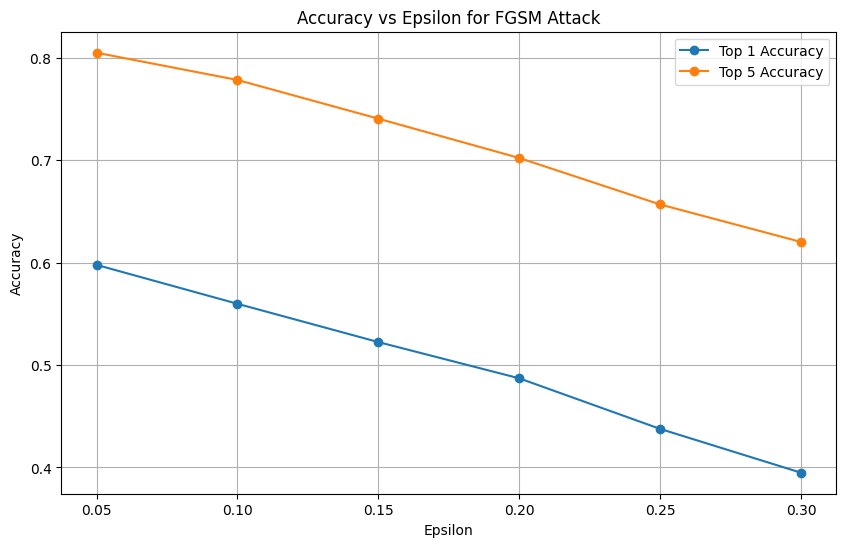

In [11]:
#@title Gráfico FGSM epsilon
# Function to loop over a list of epsilons and store accuracies
def attack_eval_model_multiple_epsilons(model='resnet', val_set='val.X', batch_size=64, atk_method='fgsm', epsilons=[0.1, 0.2, 0.3], alpha=5/255, its=43):
    epsilons_acc_top1 = []
    epsilons_acc_top5 = []

    # Loop over epsilon values
    for eps in epsilons:
        print(f'Evaluating model with epsilon: {eps}')
        acc_top1, acc_top5 = attack_eval_model_on_single(model, val_set, batch_size, atk_method, label=10, eps=eps, alpha=alpha, its=its)
        epsilons_acc_top1.append(acc_top1)
        epsilons_acc_top5.append(acc_top5)

    # Plot the results
    plot_accuracy_vs_epsilon(epsilons, epsilons_acc_top1, epsilons_acc_top5)

# Function to plot accuracy vs epsilon
def plot_accuracy_vs_epsilon(epsilons, acc_top1, acc_top5):
    plt.figure(figsize=(10,6))
    plt.plot(epsilons, acc_top1, label='Top 1 Accuracy', marker='o')
    plt.plot(epsilons, acc_top5, label='Top 5 Accuracy', marker='o')
    plt.title('Accuracy vs Epsilon for FGSM Attack')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
attack_eval_model_multiple_epsilons('resnet', 'val.X', 64, 'fgsm', epsilons)


For alpha = 2/255 and epsilon = 0.1:
Evaluating model with 1 iterations of PGD


  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-13-a6c0c1cb87dc>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(outputs, torch.tensor(mapped_labels_tensor).to(device))
100%|██████████| 79/79 [01:41<00:00,  1.28s/it]


Top 1 accuracy: 0.6234
Top 5 accuracy: 0.8308
Evaluating model with 3 iterations of PGD


100%|██████████| 79/79 [03:05<00:00,  2.35s/it]


Top 1 accuracy: 0.1924
Top 5 accuracy: 0.3232
Evaluating model with 6 iterations of PGD


100%|██████████| 79/79 [05:16<00:00,  4.01s/it]


Top 1 accuracy: 0.0722
Top 5 accuracy: 0.129
Evaluating model with 8 iterations of PGD


100%|██████████| 79/79 [06:42<00:00,  5.10s/it]


Top 1 accuracy: 0.0458
Top 5 accuracy: 0.0852
Evaluating model with 12 iterations of PGD


100%|██████████| 79/79 [09:35<00:00,  7.29s/it]


Top 1 accuracy: 0.0218
Top 5 accuracy: 0.0424
Evaluating model with 15 iterations of PGD


100%|██████████| 79/79 [11:46<00:00,  8.94s/it]


Top 1 accuracy: 0.0154
Top 5 accuracy: 0.0334


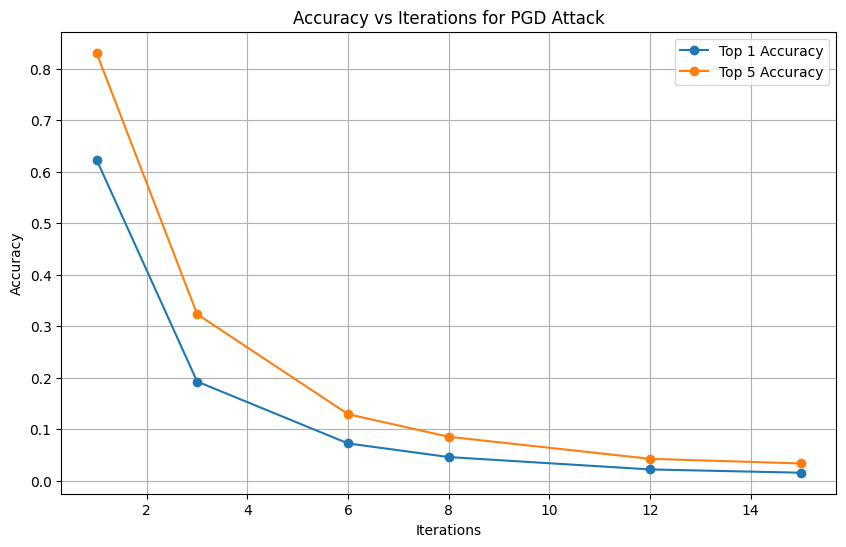

In [14]:
#@title Gráfico PGD iteraciones
# Function to loop over a list of iterations and store accuracies
def attack_eval_model_multiple_iterations(model='resnet', val_set='val.X', batch_size=64, atk_method='pgd', its_list=[1, 3, 6, 8, 12, 15], eps=0.1, alpha=5/255):
    iterations_acc_top1 = []
    iterations_acc_top5 = []

    # Loop over iteration values
    for its in its_list:
        print(f'Evaluating model with {its} iterations of PGD')
        acc_top1, acc_top5 = attack_eval_model_on_single(model, val_set, batch_size, atk_method, label=10, eps=eps, alpha=alpha, its=its)
        iterations_acc_top1.append(acc_top1)
        iterations_acc_top5.append(acc_top5)

    # Plot the results
    plot_accuracy_vs_iterations(its_list, iterations_acc_top1, iterations_acc_top5)

# Function to plot accuracy vs iterations
def plot_accuracy_vs_iterations(its_list, acc_top1, acc_top5):
    plt.figure(figsize=(10,6))
    plt.plot(its_list, acc_top1, label='Top 1 Accuracy', marker='o')
    plt.plot(its_list, acc_top5, label='Top 5 Accuracy', marker='o')
    plt.title('Accuracy vs Iterations for PGD Attack')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
iterations = [1, 3, 6, 8, 12, 15]
print('For alpha = 2/255 and epsilon = 0.1:')
attack_eval_model_multiple_iterations('resnet', 'val.X', 64, 'pgd', iterations)


Evaluating model with alpha: 0.00392156862745098


  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-13-a6c0c1cb87dc>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(outputs, torch.tensor(mapped_labels_tensor).to(device))
100%|██████████| 79/79 [08:13<00:00,  6.24s/it]


Top 1 accuracy: 0.1178
Top 5 accuracy: 0.2006
Evaluating model with alpha: 0.00784313725490196


100%|██████████| 79/79 [08:13<00:00,  6.25s/it]


Top 1 accuracy: 0.0592
Top 5 accuracy: 0.109
Evaluating model with alpha: 0.0196078431372549


100%|██████████| 79/79 [08:13<00:00,  6.25s/it]


Top 1 accuracy: 0.0292
Top 5 accuracy: 0.0608
Evaluating model with alpha: 0.0392156862745098


100%|██████████| 79/79 [08:13<00:00,  6.25s/it]


Top 1 accuracy: 0.0272
Top 5 accuracy: 0.0604
Evaluating model with alpha: 0.058823529411764705


100%|██████████| 79/79 [08:08<00:00,  6.18s/it]


Top 1 accuracy: 0.032
Top 5 accuracy: 0.0702


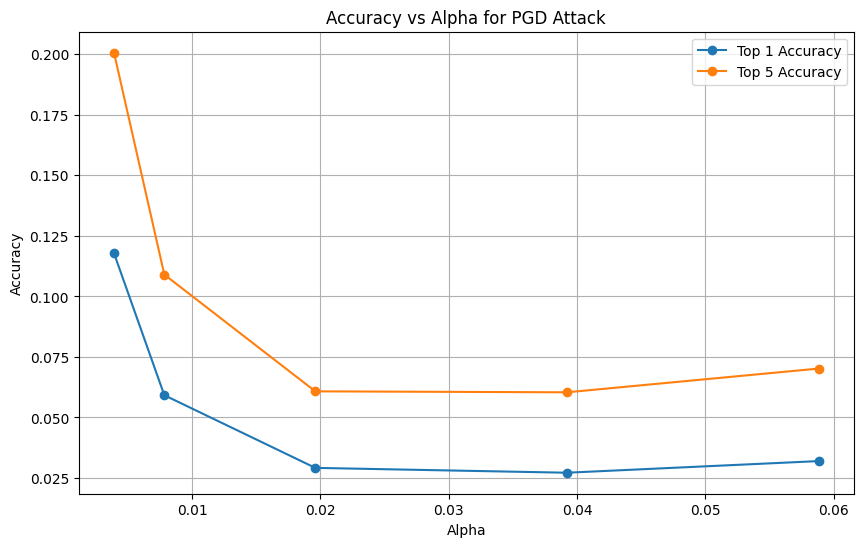

In [15]:
#@title Gráfico PGD alpha
# Function to loop over a list of alpha values and store accuracies
def attack_eval_model_multiple_alpha(model='resnet', val_set='val.X', batch_size=64, atk_method='pgd', alpha_list=[1/255, 2/255, 5/255, 10/255], eps=0.1, its=10):
    alpha_acc_top1 = []
    alpha_acc_top5 = []

    # Loop over alpha values
    for alpha in alpha_list:
        print(f'Evaluating model with alpha: {alpha}')
        acc_top1, acc_top5 = attack_eval_model_on_single(model, val_set, batch_size, atk_method, label=10, eps=eps, alpha=alpha, its=its)
        alpha_acc_top1.append(acc_top1)
        alpha_acc_top5.append(acc_top5)

    # Plot the results
    plot_accuracy_vs_alpha(alpha_list, alpha_acc_top1, alpha_acc_top5)

# Function to plot accuracy vs alpha
def plot_accuracy_vs_alpha(alpha_list, acc_top1, acc_top5):
    plt.figure(figsize=(10,6))
    plt.plot(alpha_list, acc_top1, label='Top 1 Accuracy', marker='o')
    plt.plot(alpha_list, acc_top5, label='Top 5 Accuracy', marker='o')
    plt.title('Accuracy vs Alpha for PGD Attack')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
alpha_values = [1/255, 2/255, 5/255, 10/255, 15/255]
attack_eval_model_multiple_alpha('resnet', 'val.X', 64, 'pgd', alpha_values)


## Ruido

In [35]:
import cv2

def ruido_gaussiano(img, mean = 0, sigma = 0.1):
  img = np.float64(img)     # precision
  np.random.seed(2)         # seed para la random normal
  ruido = np.random.normal(mean, sigma, img.shape)  # construir la normal
  img_ruido = img + ruido   # agregar ruido a la img

  img_ruido = np.clip(img_ruido, 0, 255)
  img_ruido = np.uint8(img_ruido)

  return img_ruido

In [36]:
correct = 0
correct_5 = 0
total = 0

model, test_loader = load_model_and_dataloader('resnet', 'val.X', 64)
imgnet1k_labels, imgnet100_labels, mapped_indices = get_labels()

for x, y in tqdm(test_loader):
    # Enable gradient computation for the input
    x = x.to(device)
    x.requires_grad = True

    # Initialize list for processed images
    processed_imgs = []

    # Apply FGSM to each image in the batch
    for i in range(x.shape[0]):
        x_i = x[i].unsqueeze(0).to(device)  # Unsqueeze to add batch dimension (1, channels, height, width)
        y_i = y[i].unsqueeze(0).to(device)  # Get the corresponding label

        x_i_np = x_i.squeeze(0).detach().cpu().numpy()  # Convert to NumPy and remove batch dimension

        # # Handle the scaling from [0, 1] to [0, 255] if needed
        # if x_i_np.max() <= 1:
        #     x_i_np = x_i_np * 255  # Rescale if in the range [0, 1]

        # Apply Gaussian noise using the ruido_gaussiano function with reduced sigma
        x_i_np_noisy = ruido_gaussiano(x_i_np.transpose(1, 2, 0), mean=0, sigma=0.01)

        # Convert the noisy image back to a PyTorch tensor and apply normalization
        x_i_noisy = torch.from_numpy(x_i_np_noisy.transpose(2, 0, 1)).unsqueeze(0).float().div(255).to(device)

        # Normalize to the mean and std used during model training (for ResNet, for example)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        x_i_noisy = normalize(x_i_noisy.squeeze(0)).unsqueeze(0).to(device)  # Apply normalization


        processed_imgs.append(x_i_noisy.squeeze(0))  # Remove the batch dimension after processing

    # Re-stack the processed images back into a batch
    x_adv = torch.stack(processed_imgs)

    # Now use no_grad for inference on adversarial images
    with torch.no_grad():
        y_pred = model(x_adv.to(device))

        # Map predictions and ground truth to label format
        y_imgnet100 = np.array([imgnet100_labels[idx.item()] for idx in y])
        y_pred_imgnet1k = np.array([imgnet1k_labels[idx.item()] for idx in y_pred.argmax(axis=1)])

        # Top 1 accuracy
        correct += (y_pred_imgnet1k == y_imgnet100).sum().item()

        # Calculate top 5 predictions
        top5_idxs = np.argpartition(y_pred.cpu(), kth=-5, axis=-1)[:, -5:].flip(dims=(1,))
        top5_preds = np.array([[imgnet1k_labels[k.item()] for k in keys] for keys in top5_idxs])
        y_in_top5 = [y_imgnet100[row] in top5_row for row, top5_row in enumerate(top5_preds)]
        correct_5 += sum(y_in_top5)

        total += len(y)

# Print final results
print(f"Top 1 accuracy: {correct/total}")
print(f"Top 5 accuracy: {correct_5/total}")

100%|██████████| 79/79 [01:42<00:00,  1.30s/it]

Top 1 accuracy: 0.349
Top 5 accuracy: 0.5644


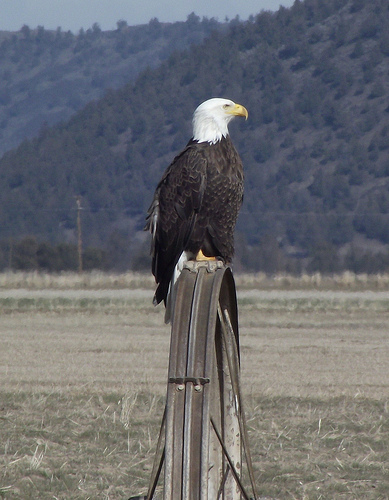

In [31]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/val.X/n01614925/ILSVRC2012_val_00006571.JPEG')

# Add Gaussian noise with a fixed seed
noisy_image = ruido_gaussiano(image, mean = 0, sigma = 0.1)

# Save or display the noisy image
cv2.imwrite('noisy_image_with_seed.jpg', noisy_image)
cv2_imshow(noisy_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Gauss test

In [24]:
def ruido_gaussiano_torch(img_tensor, mean=0, sigma=0.01):
    # Assuming the image is in [C, H, W] format and pixel values are in [0, 1]
    ruido = torch.normal(mean=torch.full_like(img_tensor, mean), std=torch.full_like(img_tensor, sigma/255))
    img_tensor_ruido = img_tensor + ruido

    # Clip the resulting image to keep it in the valid range [0, 1]
    img_tensor_ruido = torch.clamp(img_tensor_ruido, 0, 1)

    return img_tensor_ruido


In [ ]:
for x, y in tqdm(test_loader):
    # Initialize list for processed images
    processed_imgs = []

    # Apply Gaussian noise to each image in the batch
    for i in range(x.shape[0]):
        x_i = x[i].unsqueeze(0).to(device)  # Unsqueeze to add batch dimension (1, channels, height, width)
        y_i = y[i].unsqueeze(0).to(device)  # Get the corresponding label

        # Apply Gaussian noise directly to the tensor
        x_i_noisy = ruido_gaussiano_torch(x_i)  # No need for transposing or converting to NumPy

        processed_imgs.append(x_i_noisy.squeeze(0))  # Remove the batch dimension after processing

    # Re-stack the processed images back into a batch
    x_adv = torch.stack(processed_imgs)

    # Now use no_grad for inference on adversarial images
    with torch.no_grad():
        y_pred = model_resnet(x_adv.to(device))

        # Map predictions and ground truth to label format
        y_imgnet100 = np.array([imgnet100_labels[idx.item()] for idx in y])
        y_pred_imgnet1k = np.array([imgnet1k_labels[idx.item()] for idx in y_pred.argmax(axis=1)])

        # Top 1 accuracy
        correct += (y_pred_imgnet1k == y_imgnet100).sum().item()

        # Calculate top 5 predictions
        top5_idxs = np.argpartition(y_pred.cpu(), kth=-5, axis=-1)[:, -5:].flip(dims=(1,))
        top5_preds = np.array([[imgnet1k_labels[k.item()] for k in keys] for keys in top5_idxs])
        y_in_top5 = [y_imgnet100[row] in top5_row for row, top5_row in enumerate(top5_preds)]
        correct_5 += sum(y_in_top5)

        total += len(y)

# Print final results
print(f"Top 1 accuracy: {correct/total}")
print(f"Top 5 accuracy: {correct_5/total}")


100%|██████████| 79/79 [00:53<00:00,  1.48it/s]

Top 1 accuracy: 0.43833333333333335
Top 5 accuracy: 0.5726


  0%|          | 0/79 [00:00<?, ?it/s]

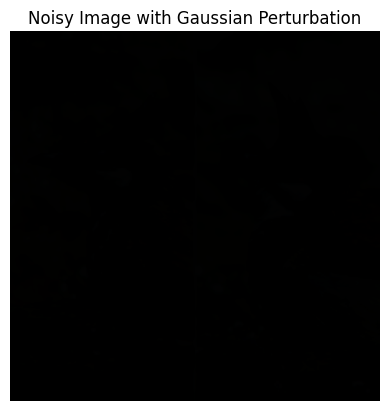

  0%|          | 0/79 [00:00<?, ?it/s]


In [27]:
import matplotlib.pyplot as plt
model, test_loader = load_model_and_dataloader('resnet', 'val.X', 64)
# Assuming test_loader is a DataLoader with batches of images
for x, y in tqdm(test_loader):
    # Only process the first image of the first batch to display
    x_i = x[0].unsqueeze(0).to(device)  # Unsqueeze to add batch dimension (1, channels, height, width)
    y_i = y[0].unsqueeze(0).to(device)  # Get the corresponding label

    # Apply Gaussian noise directly to the tensor
    x_i = x_i / 255.0  # Scale pixel values to [0, 1]
    x_i_noisy = ruido_gaussiano_torch(x_i, sigma=0.01)

    # Move the image back to the CPU and convert to NumPy
    noisy_image = x_i_noisy.squeeze(0).cpu().numpy()  # Remove batch dimension, then move to CPU and convert to NumPy

    # Convert from [C, H, W] to [H, W, C] for matplotlib
    noisy_image = noisy_image.transpose(1, 2, 0)

    # Display the noisy image using matplotlib
    plt.imshow(noisy_image)
    plt.title("Noisy Image with Gaussian Perturbation")
    plt.axis('off')  # Turn off axis labels
    plt.show()

    break  # Break after processing the first image, since we're only displaying one image
